The train and the test data are selected from users listening history in a given time period. Note that this time period is chosen to be before the WSDM-KKBox Churn Prediction time period. The train and test sets are split based on time, and the split of public/private are based on unique user/song pairs.

Tables train.csv
msno: user id
song_id: song id
source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name: name of the layout a user sees.
source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.

target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .


test.csv
id: row id (will be used for submission)

msno: user id
song_id: song id
source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name: name of the layout a user sees.
source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.

sample_submission.csv
sample submission file in the format that we expect you to submit

id: same as id in test.csv
target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .


songs.csv
The songs. Note that data is in unicode.

song_id
song_length: in ms
genre_ids: genre category. Some songs have multiple genres and they are separated by |
artist_name
composer
lyricist
language


members.csv
user information.

msno
city
bd: age. Note: this column has outlier values, please use your judgement.
gender
registered_via: registration method
registration_init_time: format %Y%m%d
expiration_date: format %Y%m%d


song_extra_info.csv
song_id
song name - the name of the song.
isrc - International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

In [77]:
#Importing Libraries

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
import missingno as msno
import gc
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,mean_squared_error,accuracy_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,VotingClassifier,AdaBoostClassifier
from tqdm import tqdm

#### Loding the datasets

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
songs_data = pd.read_csv("songs.csv")
members_data = pd.read_csv("members.csv")

In [3]:
train_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [4]:
test_data.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0.0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1.0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2.0,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3.0,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4.0,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [5]:
songs_data.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52


In [6]:
members_data.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [7]:
train_data.info()
print(train_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   msno                19999 non-null  object
 1   song_id             19999 non-null  object
 2   source_system_tab   19932 non-null  object
 3   source_screen_name  19423 non-null  object
 4   source_type         19949 non-null  object
 5   target              19999 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 937.6+ KB
(19999, 6)


In [8]:
test_data.info()
print(test_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4999 non-null   float64
 1   msno                4999 non-null   object 
 2   song_id             4999 non-null   object 
 3   source_system_tab   4996 non-null   object 
 4   source_screen_name  4781 non-null   object 
 5   source_type         4997 non-null   object 
dtypes: float64(1), object(5)
memory usage: 1.8+ MB
(39999, 6)


In [9]:
songs_data.info()
print(songs_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   song_id      39999 non-null  object
 1   song_length  39999 non-null  int64 
 2   genre_ids    39282 non-null  object
 3   artist_name  39999 non-null  object
 4   composer     23203 non-null  object
 5   lyricist     10913 non-null  object
 6   language     39999 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB
(39999, 7)


In [10]:
members_data.info()
print(members_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB
(34403, 7)


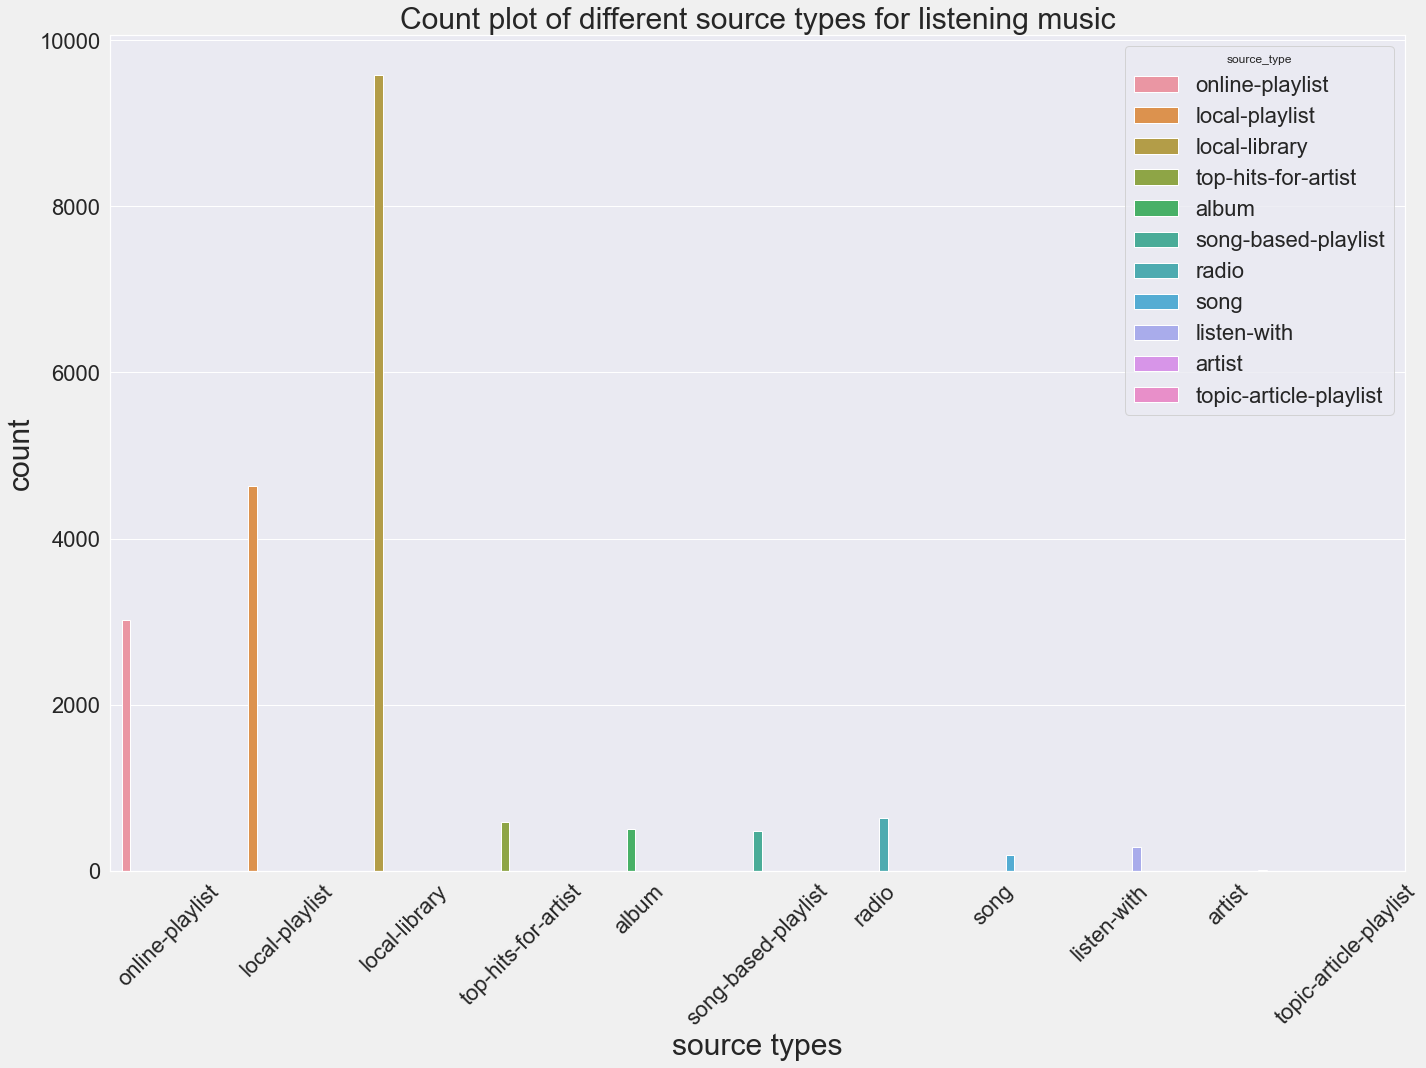

In [11]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_type',hue='source_type',data=train_data)
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot of different source types for listening music',fontsize=30)
plt.tight_layout()

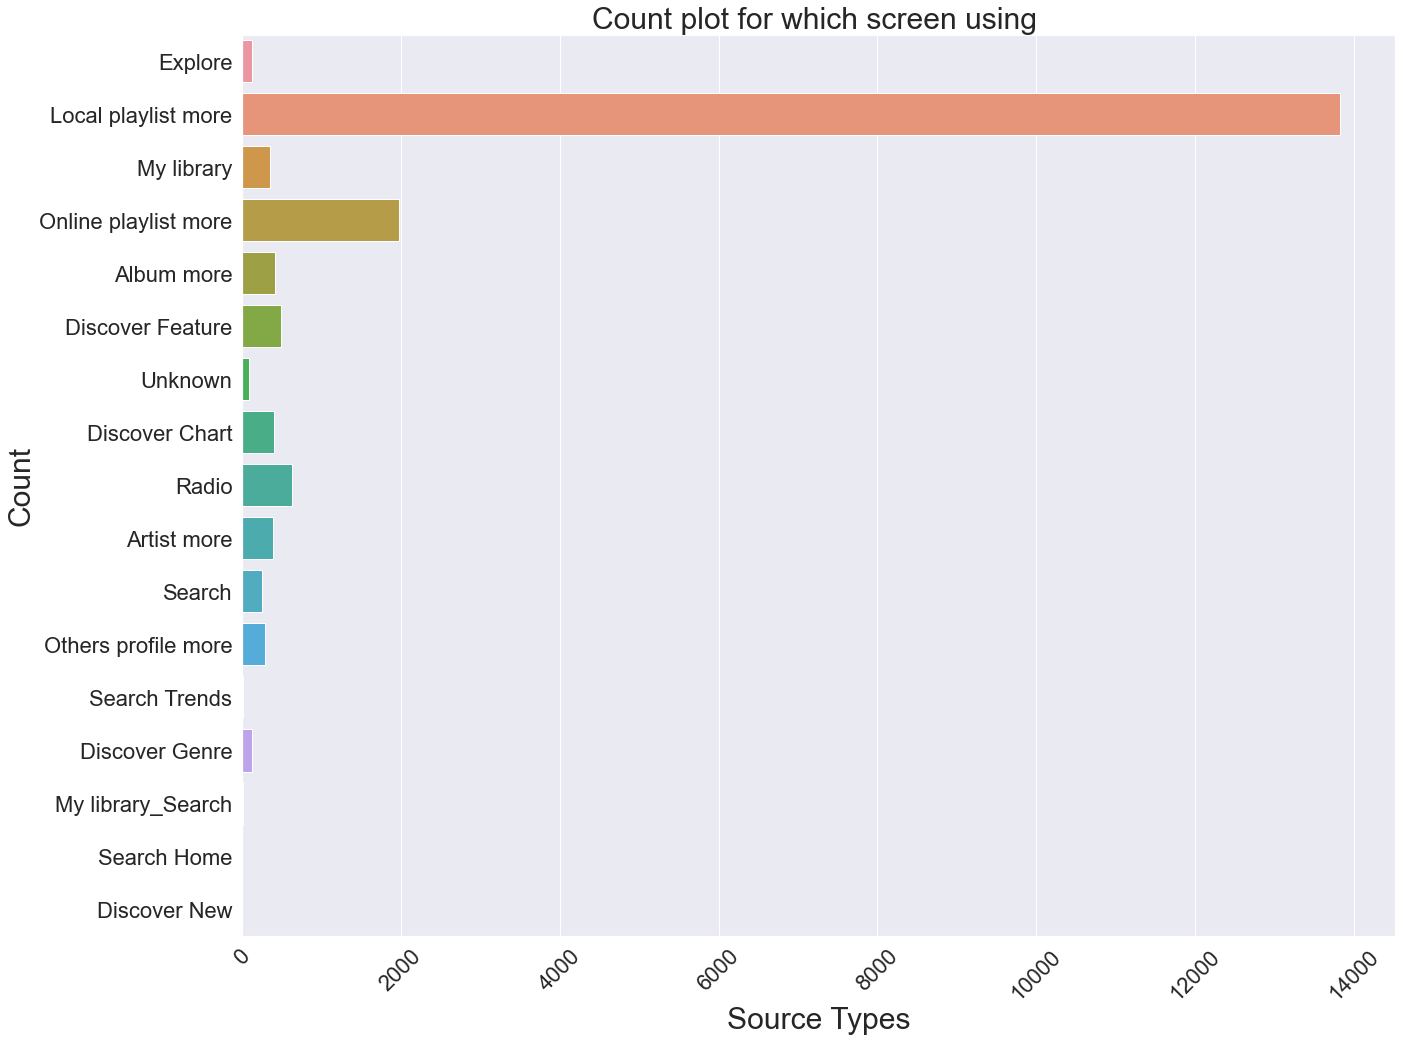

In [12]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(y='source_screen_name',data=train_data)
plt.xlabel('Source Types',fontsize=30)
plt.ylabel('Count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for which screen using ',fontsize=30)
plt.tight_layout()

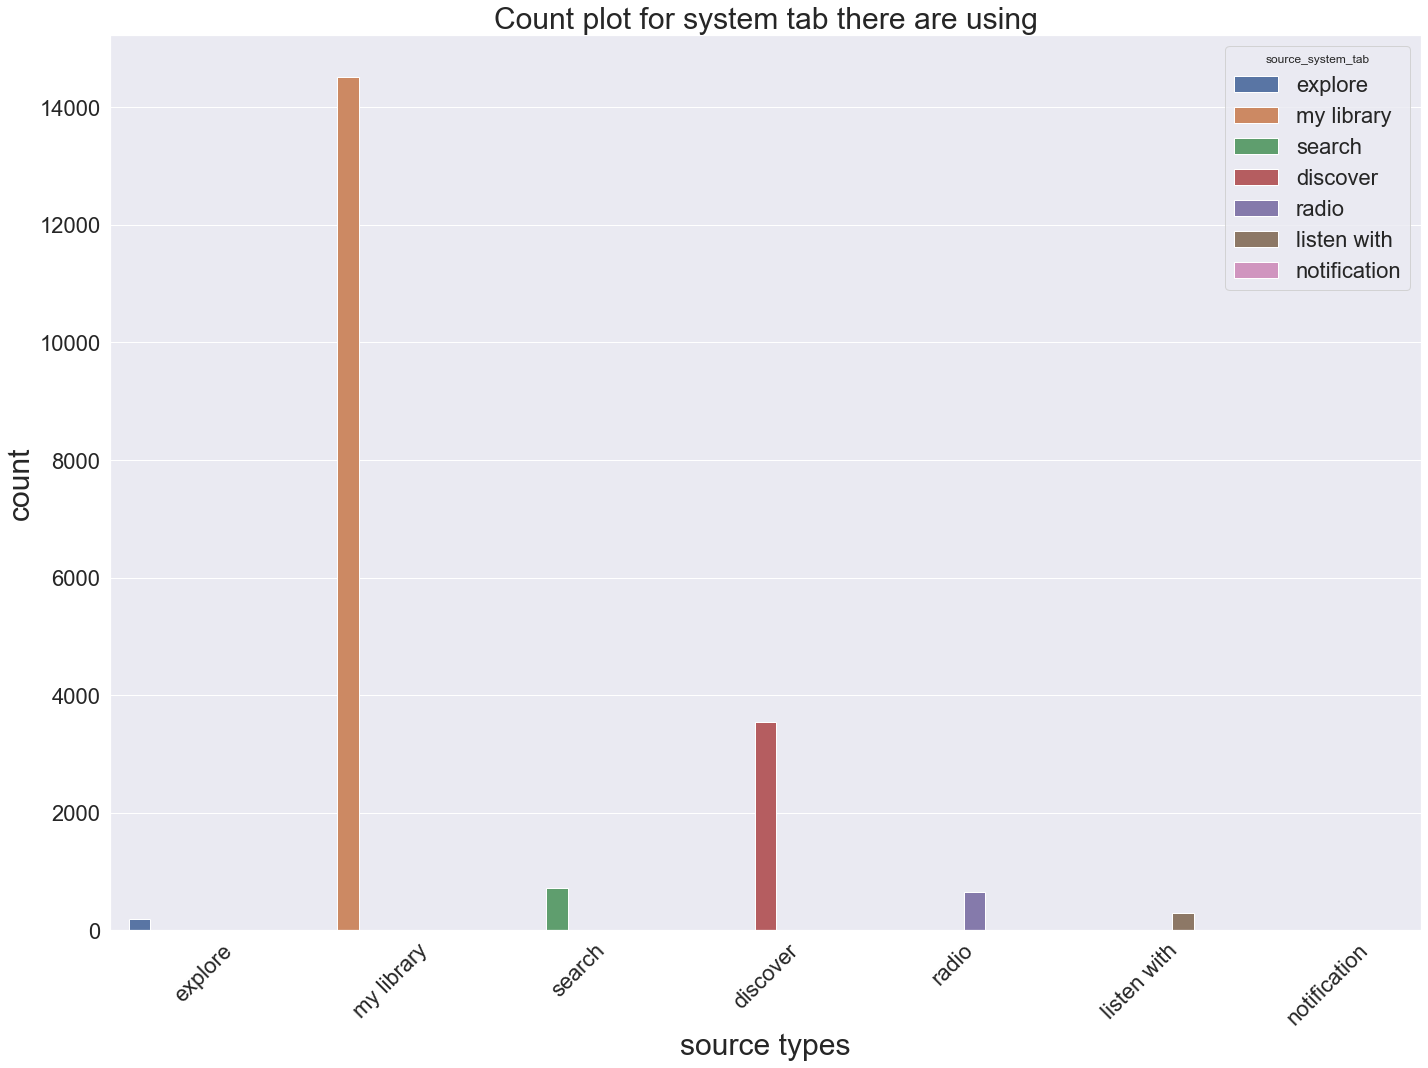

In [13]:

plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_system_tab',hue='source_system_tab',
              data=train_data)
sns.set(style="dark")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for system tab there are using',fontsize=30)
plt.tight_layout()

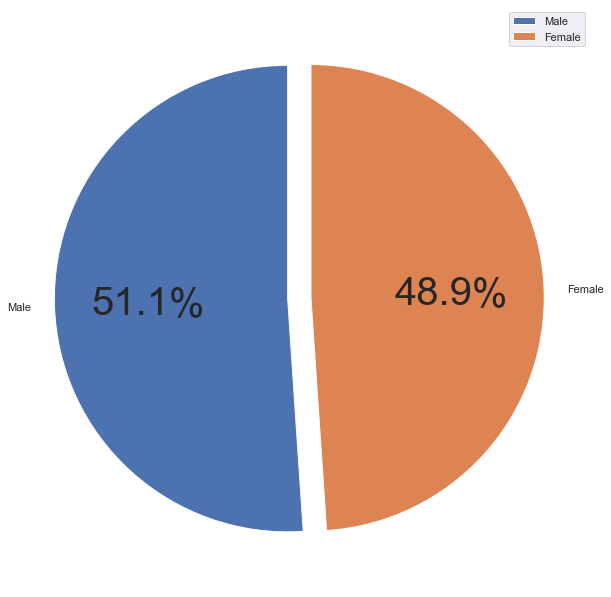

In [14]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 40.0
labels = ['Male','Female']
plt.figure(figsize = (10, 10))
sizes = pd.value_counts(members_data.gender)
patches, texts, autotexts = plt.pie(sizes, 
                                    labels=labels, autopct='%1.1f%%',
                                    shadow=False, explode= (0.05,0.05),
                                    radius=1,startangle=90)

plt.legend()
plt.show()

<Figure size 1440x1440 with 0 Axes>

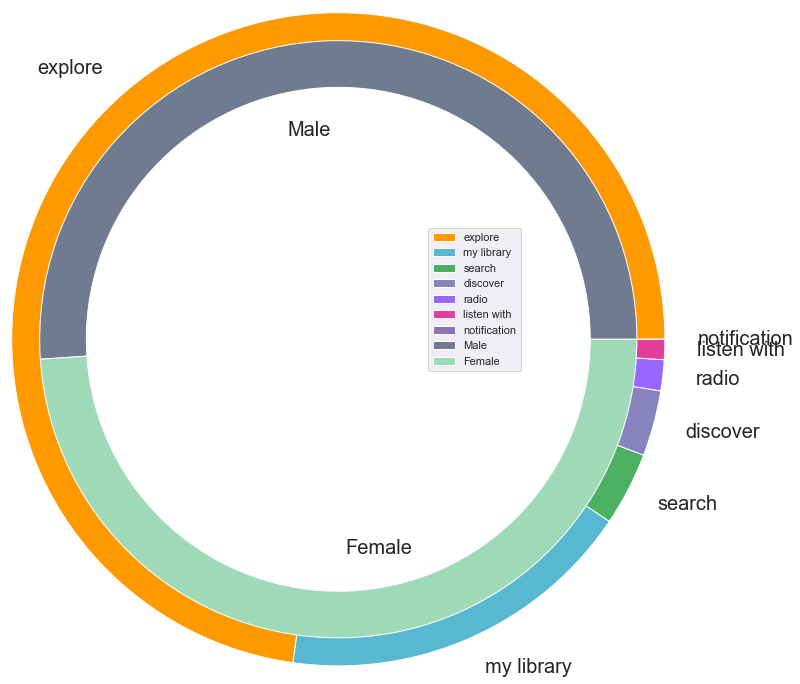

In [15]:
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 

group_names=['explore','my library','search','discover','radio','listen with','notification']
group_size=pd.value_counts(train_data.source_system_tab)
subgroup_names=['Male','Female']
subgroup_size=pd.value_counts(members_data.gender)
 

a, b, c,d,e,f,g,h=[plt.cm.autumn, plt.cm.GnBu, plt.cm.YlGn,plt.cm.Purples,plt.cm.cool,plt.cm.RdPu,plt.cm.BuPu,plt.cm.bone]
 
fig, ax = plt.subplots()
ax.axis('equal')
mypie, texts= ax.pie(group_size, radius=3.5,labels=group_names, colors=[a(0.6), b(0.6), c(0.6),d(0.6), e(0.6), f(0.6),g(0.6)])
plt.setp( mypie, width=0.5, edgecolor='white')

mypie2, texts1 = ax.pie(subgroup_size, radius=3.5-0.3, labels=subgroup_names, labeldistance=0.7, colors=[h(0.5), b(0.4)])
plt.setp( mypie2, width=0.5, edgecolor='white')
plt.margins(0,0)
for t in texts:
    t.set_size(20.0)
for t in texts1:
    t.set_size(20.0)    
plt.legend() 
plt.show()

Text(0.5, 0, 'registration time ')

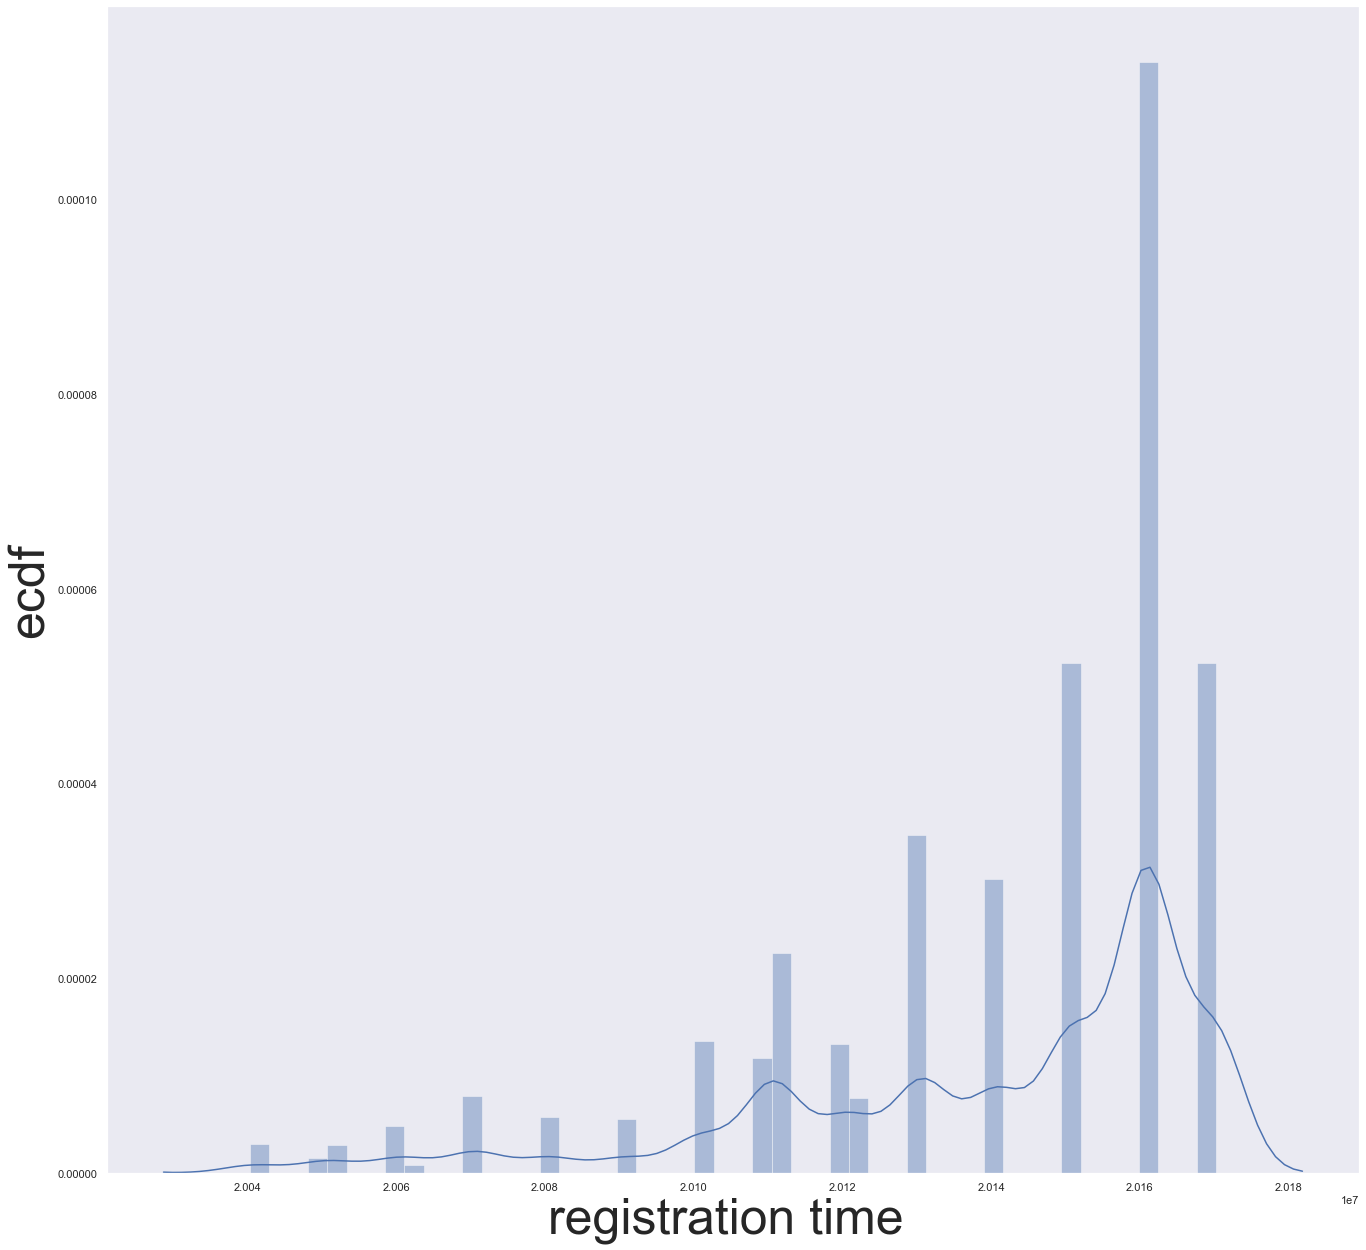

In [16]:

mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 
sns.distplot(members_data.registration_init_time)
sns.set(font_scale=2)
plt.ylabel('ecdf',fontsize=50)
plt.xlabel('registration time ' ,fontsize=50)

#### Merging datasets

In [17]:
#merging datasets
#train set
train_members = pd.merge(train_data, members_data, on='msno', how='inner')
train_merged= pd.merge(train_members, songs_data, on='song_id', how='outer')
print(train_merged.head())

#test set
test_members = pd.merge(test_data, members_data, on='msno', how='inner')
test_merged= pd.merge(test_members, songs_data, on='song_id', how='outer')
print(test_merged.head())
print(len(test_merged.columns))

                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
2  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
3  hZyOA+0yqClPLt6uIEndf8fG8szH/95eKMbaxLE5z30=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   
2  3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=           explore   
3  3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=          discover   
4  bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=           explore   

  source_screen_name      source_type  target  city    bd gender  \
0            Explore  online-playlist     1.0   1.0   0.0    NaN   
1            Explore  online-playlist     1.0   1.0   0.0    NaN   
2            Explore  online-playlist     1.0   1.0   0.0    NaN   
3     

In [18]:
print(train_merged.columns.to_series().groupby(train_merged.dtypes).groups)
print('\n')
print(test_merged.columns.to_series().groupby(test_merged.dtypes).groups)

{dtype('float64'): Index(['target', 'city', 'bd', 'registered_via', 'registration_init_time',
       'expiration_date', 'song_length', 'language'],
      dtype='object'), dtype('O'): Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'gender', 'genre_ids', 'artist_name', 'composer',
       'lyricist'],
      dtype='object')}


{dtype('float64'): Index(['id', 'city', 'bd', 'registered_via', 'registration_init_time',
       'expiration_date', 'song_length', 'language'],
      dtype='object'), dtype('O'): Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'gender', 'genre_ids', 'artist_name', 'composer',
       'lyricist'],
      dtype='object')}


#### Missing values

In [19]:
def check_missing_values(df):
    print(df.isnull().values.any())
    if (df.isnull().values.any()== True):
        columns_with_Nan = df.columns[df.isnull().any()].tolist()
        print(columns_with_Nan)
        for col in columns_with_Nan:
            print('%s : %d' %(col,df[col].isnull().sum()))

check_missing_values(train_merged)

True
['msno', 'source_system_tab', 'source_screen_name', 'source_type', 'target', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
msno : 38665
source_system_tab : 38732
source_screen_name : 39241
source_type : 38715
target : 38665
city : 38665
bd : 38665
gender : 46377
registered_via : 38665
registration_init_time : 38665
expiration_date : 38665
song_length : 17154
genre_ids : 17895
artist_name : 17154
composer : 34148
lyricist : 46653
language : 17154


In [20]:
check_missing_values(test_merged)

True
['id', 'msno', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
id : 39524
msno : 39524
source_system_tab : 39527
source_screen_name : 39742
source_type : 39526
city : 39524
bd : 39524
gender : 41665
registered_via : 39524
registration_init_time : 39524
expiration_date : 39524
song_length : 4298
genre_ids : 5017
artist_name : 4298
composer : 21113
lyricist : 33461
language : 4298


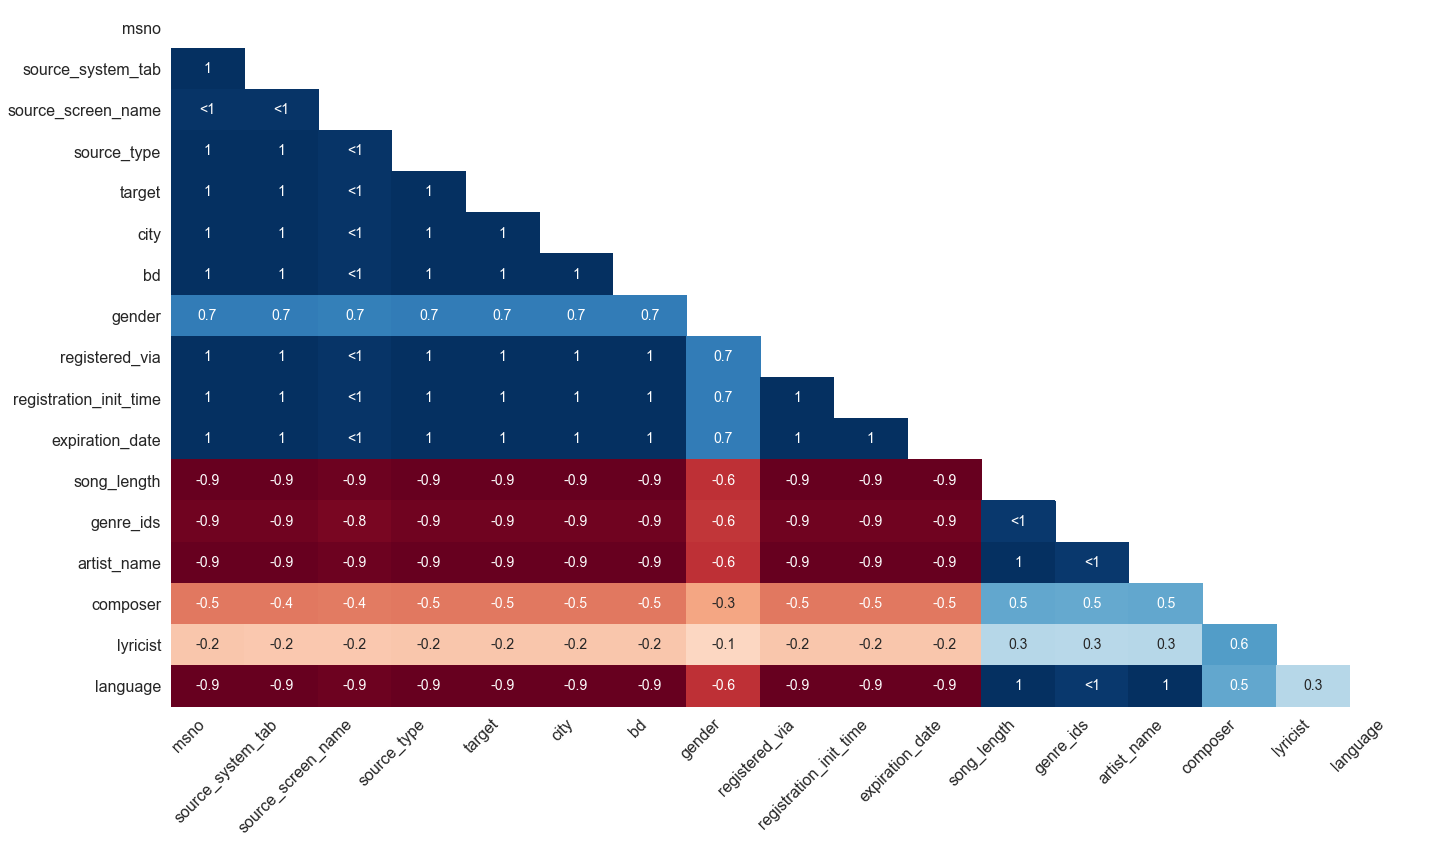

In [21]:
msno.heatmap(train_merged)

In [22]:
#Replace float values with -5
def replace_Nan_non_object(df):
    object_cols=list(df.select_dtypes(include=['float']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(np.int(-5))

replace_Nan_non_object(train_merged)
replace_Nan_non_object(test_merged)

#Missing values of object type

def replace_Nan_object(df):
    object_cols=list(df.select_dtypes(include=['object']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(' ')
    print(object_cols)

replace_Nan_object(train_merged)
replace_Nan_object(test_merged)

In [23]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

change_datatype(train_merged)
change_datatype(test_merged)

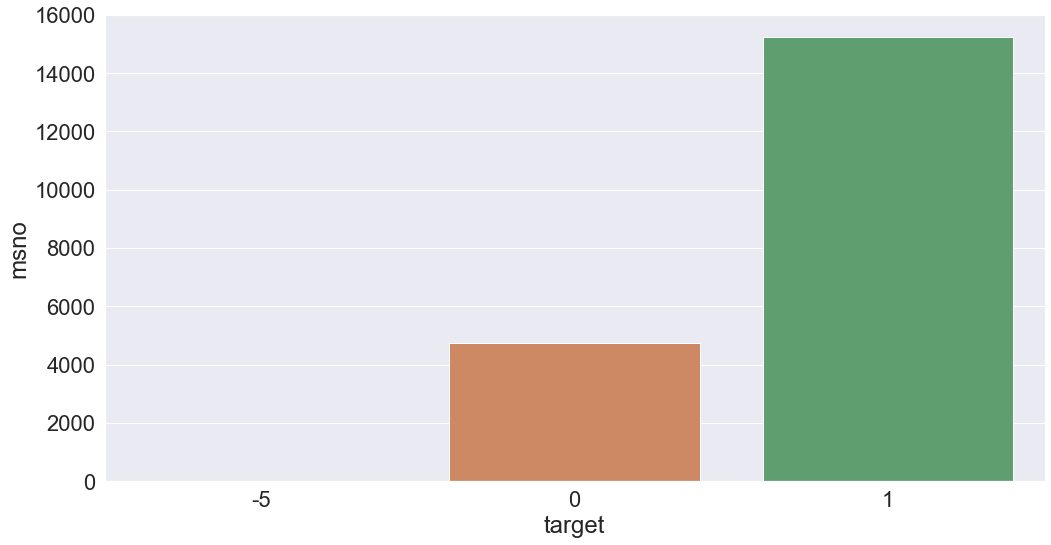

In [24]:
data = train_merged.groupby('target').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='target', y='msno', data=data)

In [25]:
train_merged= train_merged[train_merged.target != -5]
len(train_merged.index)

19999

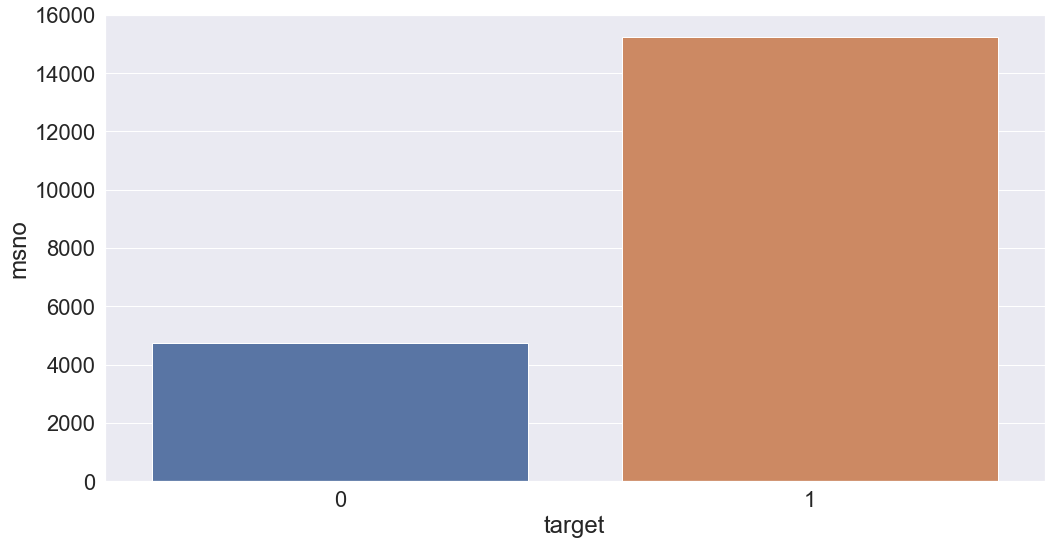

In [26]:
data = train_merged.groupby('target').aggregate({'msno':'count'}).reset_index()
a4_dims=(15,8)
fig,ax=plt.subplots(figsize=a4_dims)
ax= sns.barplot(x='target',y='msno',data=data)

[Text(0, 0, '-5'),
 Text(0, 0, '-1'),
 Text(0, 0, '3'),
 Text(0, 0, '10'),
 Text(0, 0, '17'),
 Text(0, 0, '24'),
 Text(0, 0, '31'),
 Text(0, 0, '52'),
 Text(0, 0, '59')]

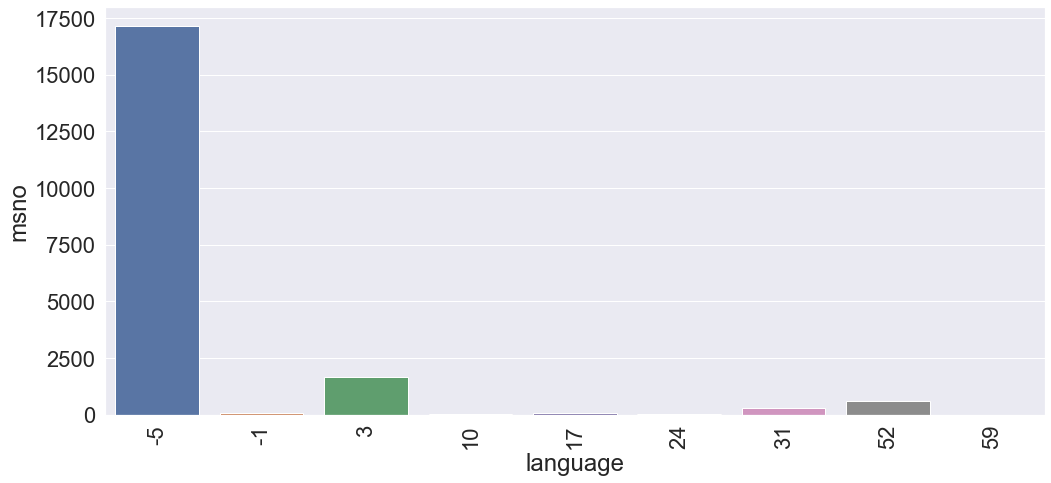

In [27]:
data = train_merged.groupby('language').aggregate({'msno':'count'}).reset_index()
a4_dims=(15,7)
fig, ax= plt.subplots(figsize=a4_dims)
ax= sns.barplot(x='language', y='msno', data= data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22')]

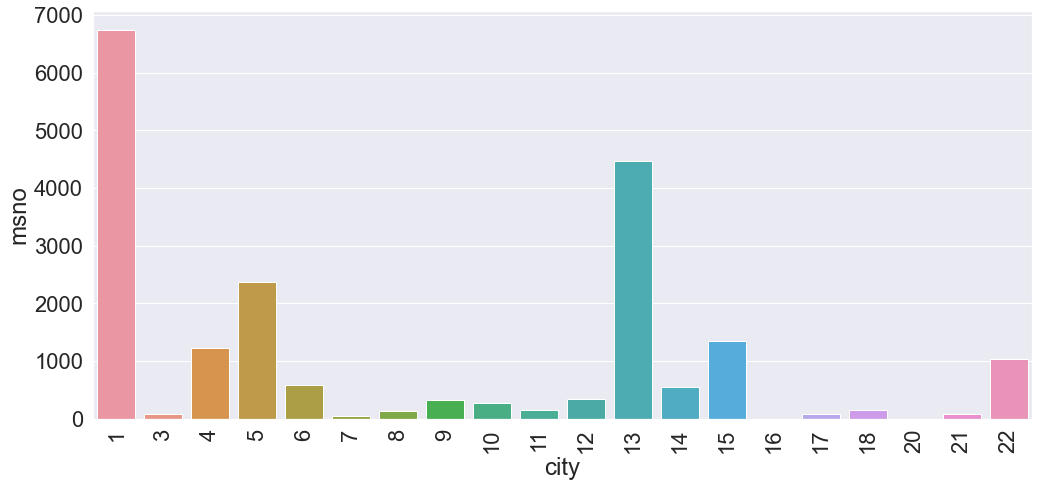

In [28]:
data = train_merged.groupby('city').aggregate({'msno':'count'}).reset_index()
a4_dims=(15,7)
fig, ax= plt.subplots(figsize=a4_dims)
ax= sns.barplot(x='city', y='msno', data= data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'Album more'),
 Text(0, 0, 'Artist more'),
 Text(0, 0, 'Discover Chart'),
 Text(0, 0, 'Discover Feature'),
 Text(0, 0, 'Discover Genre'),
 Text(0, 0, 'Discover New'),
 Text(0, 0, 'Explore'),
 Text(0, 0, 'Local playlist more'),
 Text(0, 0, 'My library'),
 Text(0, 0, 'My library_Search'),
 Text(0, 0, 'Online playlist more'),
 Text(0, 0, 'Others profile more'),
 Text(0, 0, 'Radio'),
 Text(0, 0, 'Search'),
 Text(0, 0, 'Search Home'),
 Text(0, 0, 'Search Trends'),
 Text(0, 0, 'Unknown')]

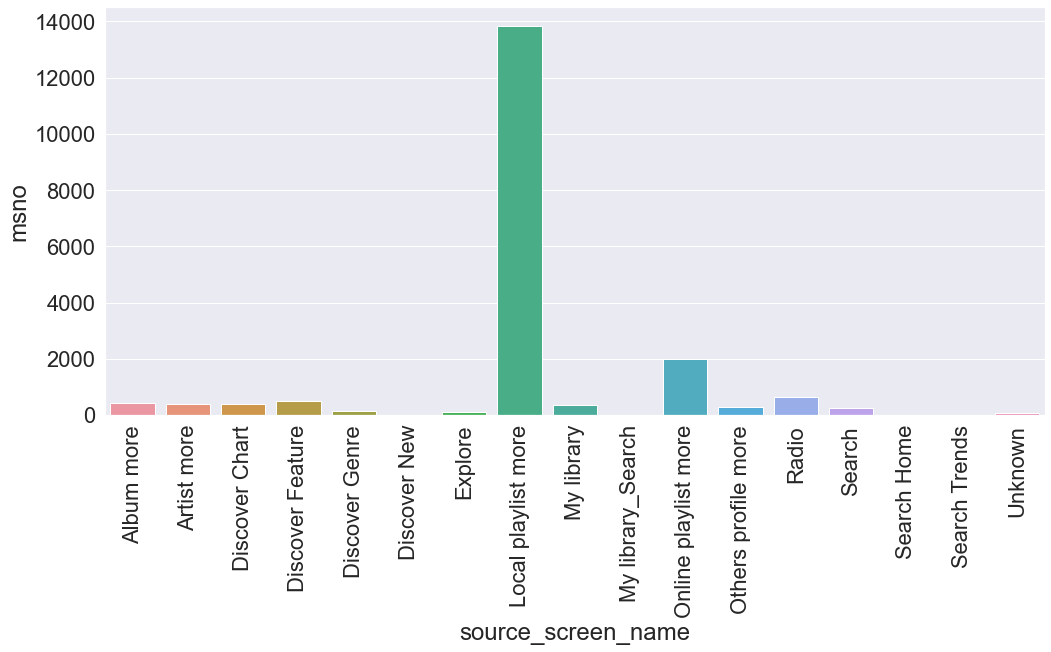

In [29]:
data = train_merged.groupby('source_screen_name').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_screen_name', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'album'),
 Text(0, 0, 'artist'),
 Text(0, 0, 'listen-with'),
 Text(0, 0, 'local-library'),
 Text(0, 0, 'local-playlist'),
 Text(0, 0, 'online-playlist'),
 Text(0, 0, 'radio'),
 Text(0, 0, 'song'),
 Text(0, 0, 'song-based-playlist'),
 Text(0, 0, 'top-hits-for-artist'),
 Text(0, 0, 'topic-article-playlist')]

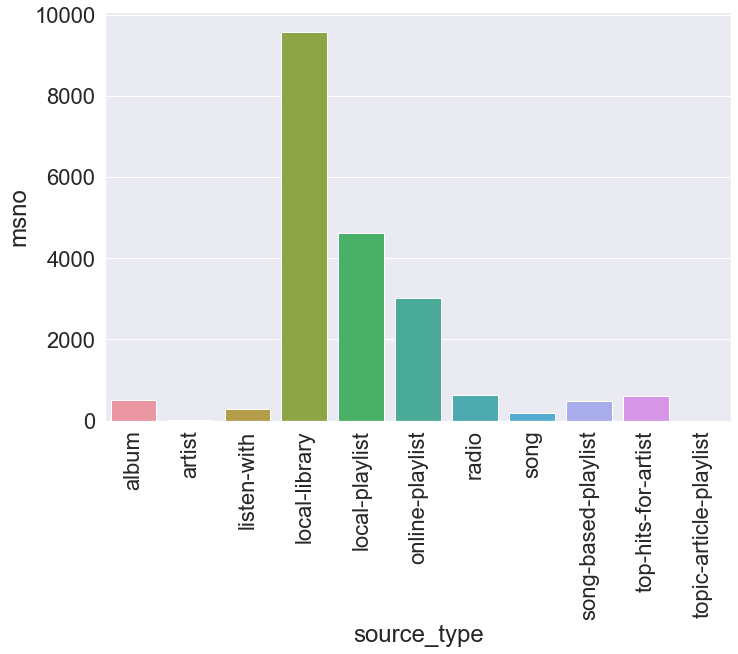

In [30]:
data = train_merged.groupby('source_type').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_type', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

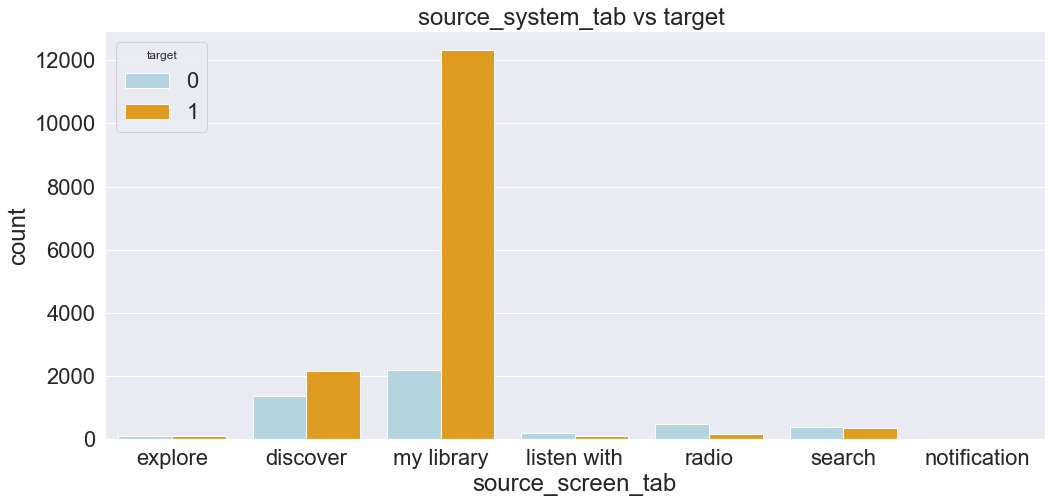

In [31]:

a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_system_tab",data=train_merged,palette=['lightblue','orange','green'],hue="target")
plt.xlabel("source_screen_tab")
plt.ylabel("count")
plt.title("source_system_tab vs target ")
plt.show()

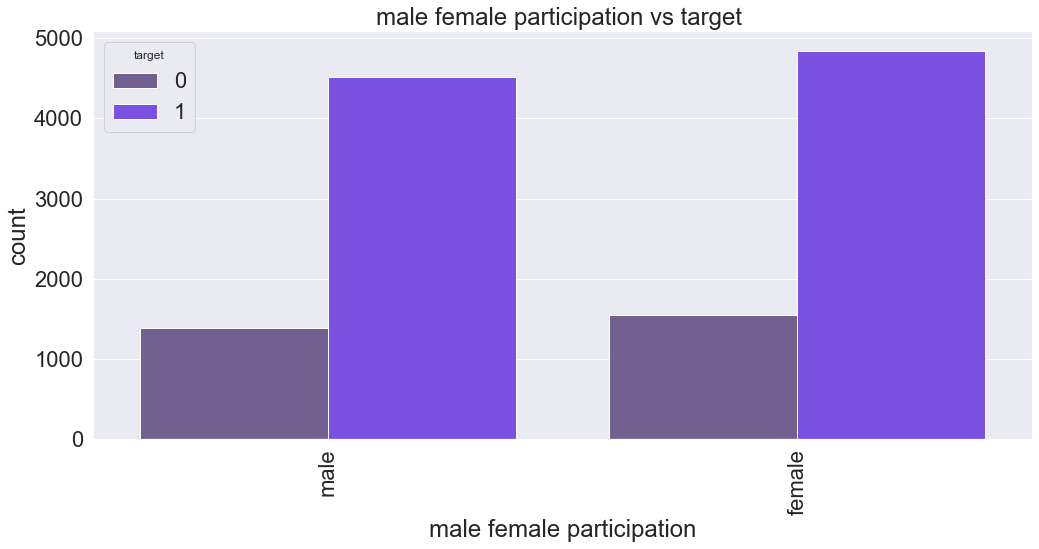

In [32]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="gender",data=train_merged,palette=['#705898','#7038F8','yellow'],hue="target")
plt.xlabel("male female participation")
plt.ylabel("count")
plt.title("male female participation vs target ")
plt.xticks(rotation='90')
plt.show()

### Modeling

In [61]:
from sklearn.preprocessing import LabelEncoder
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
songs = pd.read_csv('songs.csv')
members = pd.read_csv('members.csv')

# Merge datasets with song attributes
song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
train = train.merge(songs[song_cols], on='song_id', how='left')
test = test.merge(songs[song_cols], on='song_id', how='left')

# Merge datasets with member features
members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['registration_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['registration_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['expiration_date'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))
members = members.drop(['registration_init_time'], axis=1)

members_cols = members.columns
train = train.merge(members[members_cols], on='msno', how='left')
test = test.merge(members[members_cols], on='msno', how='left')

train = train.fillna(-1)
test = test.fillna(-1)

del members, songs; gc.collect();

cols = list(train.columns)
cols.remove('target')

for col in tqdm(cols):
    if train[col].dtype == 'object':
        train[col] = train[col].apply(str)
        test[col] = test[col].apply(str)

        le = LabelEncoder()
        train_vals = list(train[col].unique())
        test_vals = list(test[col].unique())
        le.fit(train_vals + test_vals)
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.42it/s]


In [62]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'artist_name', 'genre_ids', 'song_length',
       'language', 'city', 'bd', 'gender', 'registered_via', 'expiration_date',
       'registration_year', 'registration_month', 'registration_date',
       'expiration_year', 'expiration_month'],
      dtype='object')

In [63]:
columntitles=['target','msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type','artist_name', 'genre_ids', 'song_length',
       'language', 'city', 'bd', 'gender', 'registered_via', 'expiration_date',
       'registration_year', 'registration_month', 'registration_date',
       'expiration_year', 'expiration_month']

In [64]:
train=train.reindex(columns=columntitles)

In [65]:
x = train.iloc[:,1:]
y = train['target'].values

In [66]:

x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.3)

In [75]:
forest=RandomForestClassifier(n_estimators=600,max_depth=10,n_jobs=-1,criterion='gini',max_features=15,max_leaf_nodes=15)
forest.fit(x_train,y_train)

rf_pred_y_train = forest.predict(x_train)

In [79]:
print(classification_report(y_train, rf_pred_y_train ))
print(confusion_matrix(y_train, rf_pred_y_train ))
print('Train Accuracy {:.2f}%'.format(forest.score(x_train, y_train)*100))

              precision    recall  f1-score   support

           0       0.75      0.25      0.37      3337
           1       0.81      0.97      0.88     10662

    accuracy                           0.80     13999
   macro avg       0.78      0.61      0.63     13999
weighted avg       0.79      0.80      0.76     13999

[[  823  2514]
 [  275 10387]]
Train Accuracy 80.08%


In [81]:
rf_pred_y_test = forest.predict(x_test)
print(classification_report(y_test, rf_pred_y_test ))
print(confusion_matrix(y_test, rf_pred_y_test ))
print('Test Accuracy {:.2f}%'.format(forest.score(x_test, y_test)*100))

              precision    recall  f1-score   support

           0       0.67      0.22      0.33      1419
           1       0.80      0.97      0.88      4581

    accuracy                           0.79      6000
   macro avg       0.74      0.59      0.60      6000
weighted avg       0.77      0.79      0.75      6000

[[ 314 1105]
 [ 152 4429]]
Test Accuracy 79.05%


In [82]:
accuracy1=[]
accuracy0=[]
n_estimators=range(200,1000,100)
for n in n_estimators:
    forest=RandomForestClassifier(n_estimators=n,max_depth=10,n_jobs=-1,criterion='gini',max_features=15,max_leaf_nodes=15)
    forest.fit(x_train,y_train)
    accuracy1.append(forest.score(x_test,y_test))
    accuracy0.append(forest.score(x_train,y_train))

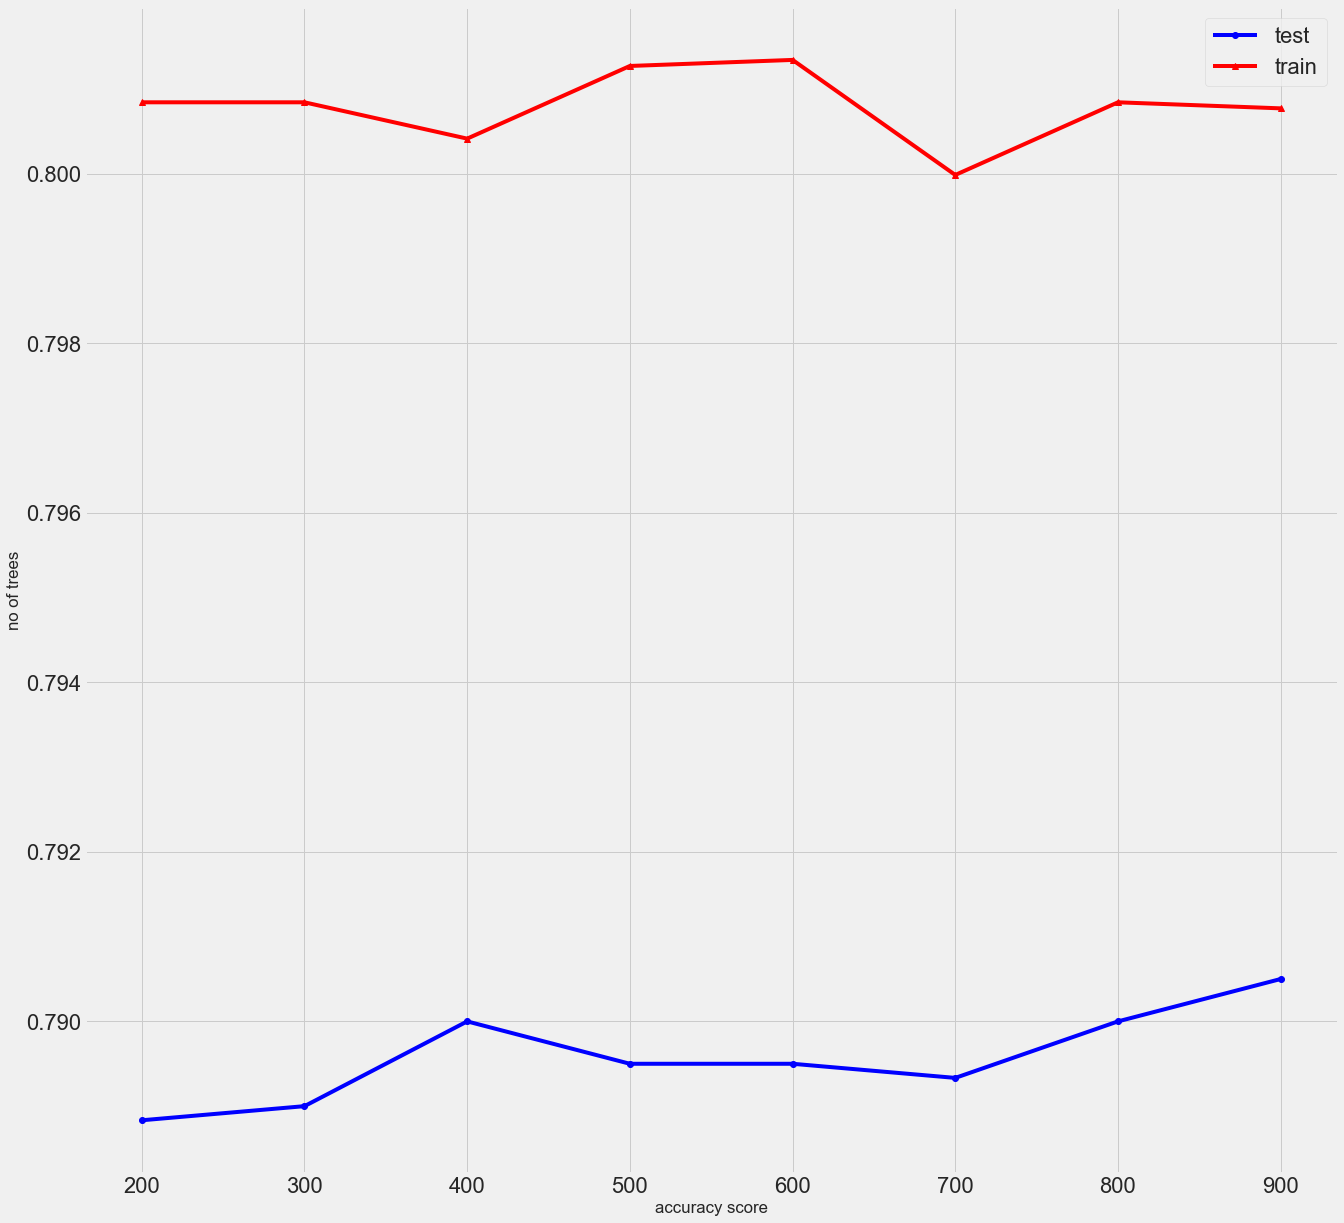

In [83]:
plt.figure(figsize=(20,20))    
plt.plot(n_estimators,accuracy1,'-o',color='blue',label="test")
plt.plot(n_estimators,accuracy0,'-^',color='red',label="train")
plt.xlabel('accuracy score')
plt.ylabel('no of trees')
plt.legend()
plt.show()

In [84]:

rmse0=[]
rmse1=[]
for n in n_estimators:
    forest=RandomForestClassifier(n_estimators=n,max_depth=10,n_jobs=-1,criterion='gini',max_features=15,max_leaf_nodes=15)
    forest.fit(x_train,y_train)
    y_pred0=forest.predict(x_train)
    y_pred1=forest.predict(x_test)
    rmse0.append(np.sqrt(mean_squared_error(y_pred0,y_train)))
    rmse1.append(np.sqrt(mean_squared_error(y_pred1,y_test)))

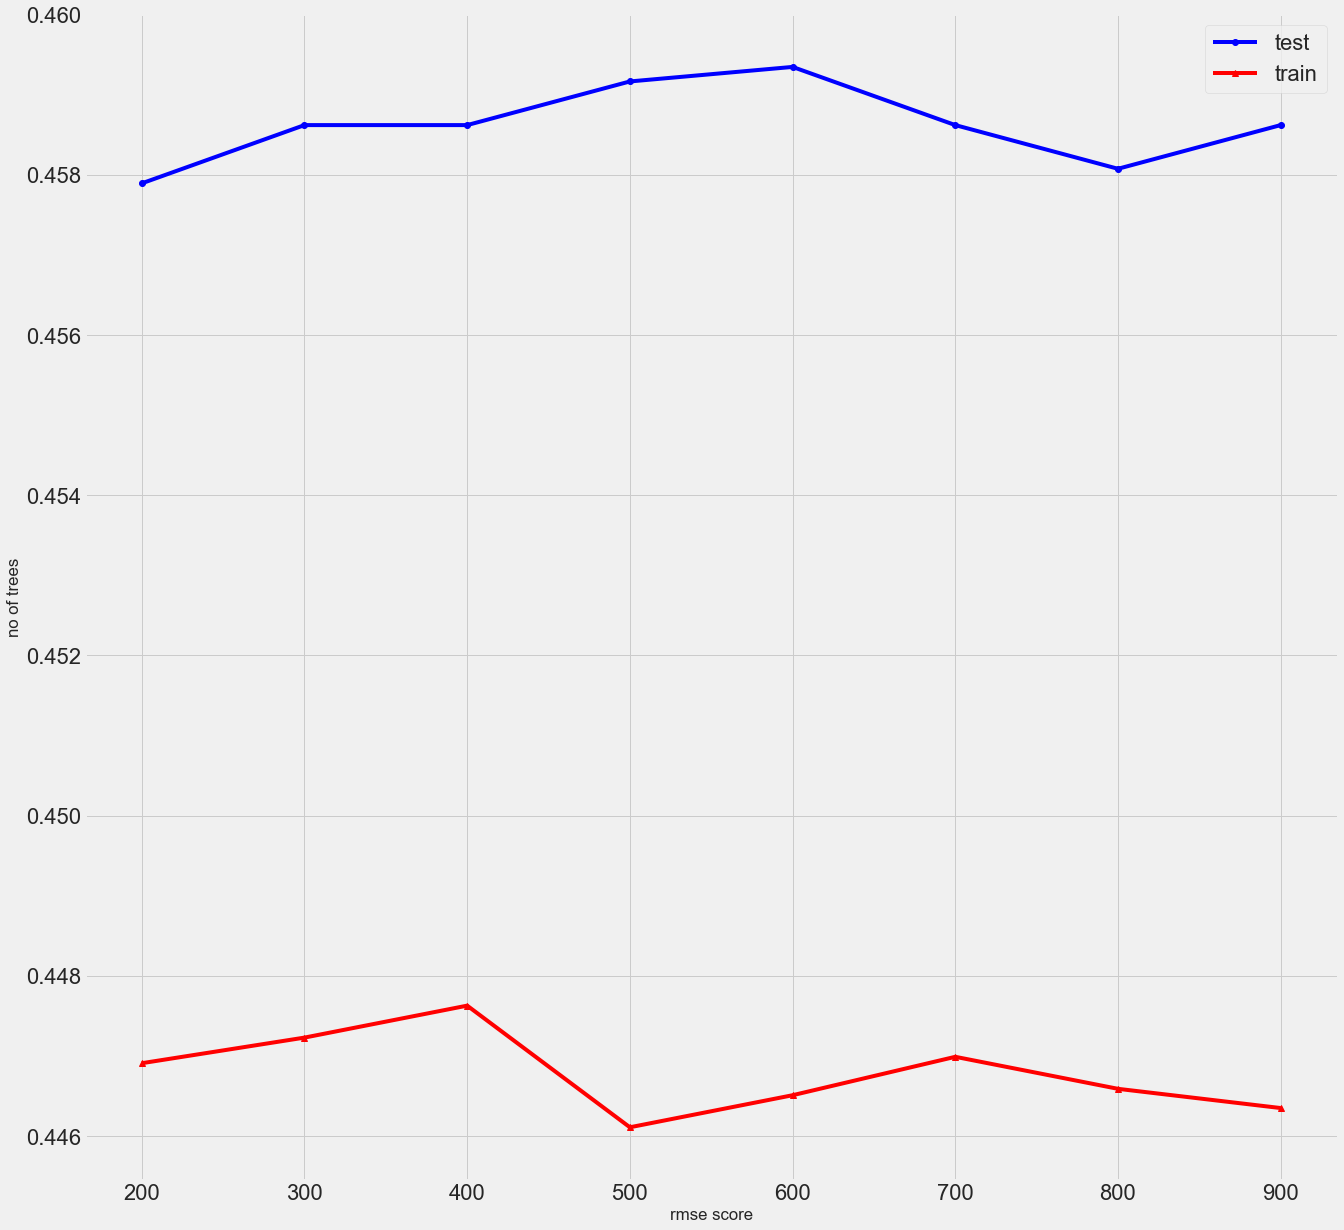

In [85]:
plt.figure(figsize=(20,20))    
plt.plot(n_estimators,rmse1,'-o',color='blue',label="test")
plt.plot(n_estimators,rmse0,'-^',color='red',label="train")
plt.xlabel('rmse score')
plt.ylabel('no of trees')
plt.legend()
plt.show()

In [88]:
gboost= XGBClassifier(learning_rate=0.1, max_depth= 15, min_child_weight=5,n_estimators= 250)


gboost.fit(x_train,y_train)
gboost_pred_y_train = gboost.predict(x_train)

In [90]:
print(classification_report(y_train, gboost_pred_y_train ))
print(confusion_matrix(y_train, gboost_pred_y_train ))
print('Train Accuracy {:.2f}%'.format(gboost.score(x_train, y_train)*100))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      3337
           1       0.96      0.99      0.98     10662

    accuracy                           0.97     13999
   macro avg       0.97      0.94      0.95     13999
weighted avg       0.97      0.97      0.97     13999

[[ 2949   388]
 [   89 10573]]
Train Accuracy 96.59%


In [91]:
gboost_pred_y_test = gboost.predict(x_test)
print(classification_report(y_test, gboost_pred_y_test ))
print(confusion_matrix(y_test, gboost_pred_y_test ))
print('Test Accuracy {:.2f}%'.format(gboost.score(x_test, y_test)*100))

              precision    recall  f1-score   support

           0       0.70      0.55      0.61      1419
           1       0.87      0.93      0.90      4581

    accuracy                           0.84      6000
   macro avg       0.78      0.74      0.76      6000
weighted avg       0.83      0.84      0.83      6000

[[ 778  641]
 [ 339 4242]]
Test Accuracy 83.67%
